# Explain Like I'm Five (ELI5) basic overview of vectorization and how to apply it to Python

In [1]:
import numpy as np
import pandas as pd
import time
import random
from itertools import permutations, combinations

Take a look at this problem we have here. We have two big arrays that need to be multiplied and summed:

In [2]:
a = np.random.rand(30000000) #this creates a random array of length 30,000,000
b = np.random.rand(30000000)

If we were to do this by hand, we would take each element of the list, multiply them, and then add them to the sum. Let's see what that would look like in a for loop. (Warning: this may take around 20 seconds)

In [3]:
def sum_func(a, b):
    ab_sum = 0
    for i in range(0, len(a)):
        ab_sum += a[i] * b[i]
    return ab_sum

In [4]:
time1 = time.process_time()
sample = sum_func(a, b)
time2 = time.process_time()

In [5]:
runtime = time2 - time1
print('For Loop time elapsed ~ {} seconds'.format(runtime))

For Loop time elapsed ~ 18.7357201 seconds


The reason why this is slow is because it is calculating it one by one. It is calcuating a[0] * b[0], then adding it to the sum, and it then it calculates a[1] * b[1], then adds it to the sum etc. all the way to 30,000,000. It is waiting for each calculation to finish before moving on to the next one. 

The thing is, with this particular problem, we don't need to wait for each one to finish. a[1] * b[1] is not depenedent on anything else in the array, so there's no point in waiting for a[0] * b[0] to finish before calculating the rest of the array. Let's vectorize it. 

Tip: In order to pass two arrays or lists into two separate columns into a pandas dataframe, you must pass them into a dictionary first. You don't have create a new dictionary variable, this is just for readability.

In [6]:
ab_dict = {'a': a, 'b': b}
ab_df = pd.DataFrame(ab_dict)

You could also create two separate series (a series is similar to a dataframe, except it is just one-dimensional with an index): 

In [7]:
a_series = pd.Series(a)
b_series = pd.Series(b)

We can achieve a vectorized implementation with both datatypes:

In [8]:
ab_df['multiplied'] = ab_df['a'] * ab_df['b']
print(ab_df['multiplied'].sum())

ab_series = a_series * b_series
print(ab_series.sum())

7501187.615509808
7501187.615509808


That was much faster, and we ran the operation twice in a fraction of the time! Let's create a function for both implementations:

In [9]:
def df_mult(a, b):
    ab_dict = {'a': a, 'b': b}
    ab_df = pd.DataFrame(ab_dict)
    ab_df['multiplied'] = ab_df['a'] * ab_df['b']
    return ab_df['multiplied'].sum()

In [10]:
def ser_mult(a, b):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    ab_series = a_series * b_series
    return ab_series.sum()

In [11]:
time1 = time.process_time()
sample = df_mult(a, b)
time2 = time.process_time()
runtime = time2 - time1
print('DataFrame Multiplication time elapsed ~ {} seconds'.format(runtime))

DataFrame Multiplication time elapsed ~ 1.2948082999999997 seconds


In [12]:
time1 = time.process_time()
sample = ser_mult(a, b)
time2 = time.process_time()
runtime = time2 - time1
print('Series Multiplication time elapsed ~ {} seconds'.format(runtime))

Series Multiplication time elapsed ~ 0.7332047000000017 seconds


With either implementation, you can get an extremely efficient function. There are pros and cons to using Series vs DataFrames for certain problems. Series are faster for calcuations because you don't have to load them into a DataFrame, but you have to create a new variable for each Series when you do an operation. DataFrames can be great for readability and keeping things nice and organized.

### Euler Problems

Let's solve an Euler problem with vectorization and compare the run-time speeds. https://projecteuler.net

#### Problem 43

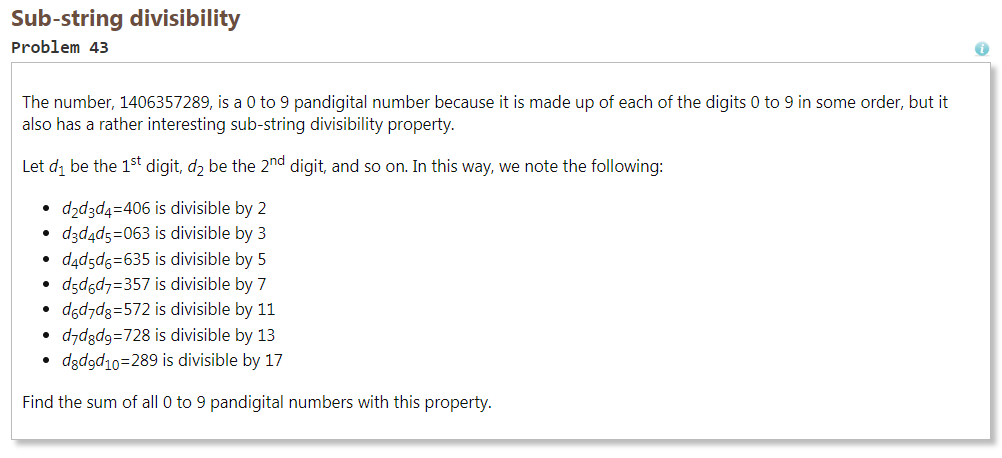

Here is a sample for-loop implementation: (We have to up the 'n' parameter as such a small operation doesn't output enough nanoseconds)

In [13]:
from itertools import permutations

def for_loop():
    perm_list = list(permutations([str(x) for x in range(0, 10)], 10))
    op_list = [2, 3, 5, 7, 11, 13, 17]
    sum_list = []
    for perm in perm_list:
        check = False
        for i in range(1, 8)[::-1]:
            subset = int(''.join(perm[i:i+3]))
            if subset % op_list[i-1] == 0:
                check = True
            else: 
                check = False
                break
        if check:
            sum_list.append(int(''.join(perm)))

    return sum(sum_list)

In [14]:
time1 = time.process_time()
sample = for_loop()
time2 = time.process_time()
runtime = time2 - time1
print('For Loop time elapsed ~ {} seconds'.format(runtime))
print(sample)

For Loop time elapsed ~ 5.569235699999997 seconds
16695334890


In [15]:
def df_vec():
    digits = pd.Series(permutations([str(x) for x in range(0, 10)], 10)).apply(''.join)
    df = pd.DataFrame(digits, columns = ['base'])
    op_list = [2, 3, 5, 7, 11, 13, 17]
    def get_subset(x):
        return(x[i:i+3])
    for i in range(1,8)[::-1]:
        df[str(i)] = df['base'].apply(get_subset).astype(int)
        df['mod-' + str(i)] = df[str(i)]%op_list[i-1]
        df = df[df['mod-' + str(i)] == 0]
    return df['base'].astype(float).sum()

In [16]:
time1 = time.process_time()
sample = df_vec()
time2 = time.process_time()
runtime = time2 - time1
print('Vec time elapsed ~ {} seconds'.format(runtime))
print(sample)

Vec time elapsed ~ 4.539629099999999 seconds
16695334890.0


For such a small set of data, we won't see a huge increase in performance (1 second is still a good improvement in computer terms). However, when we start to get to larger and larger sets of data, this is where vectorization starts to shine.

#### Euler 23

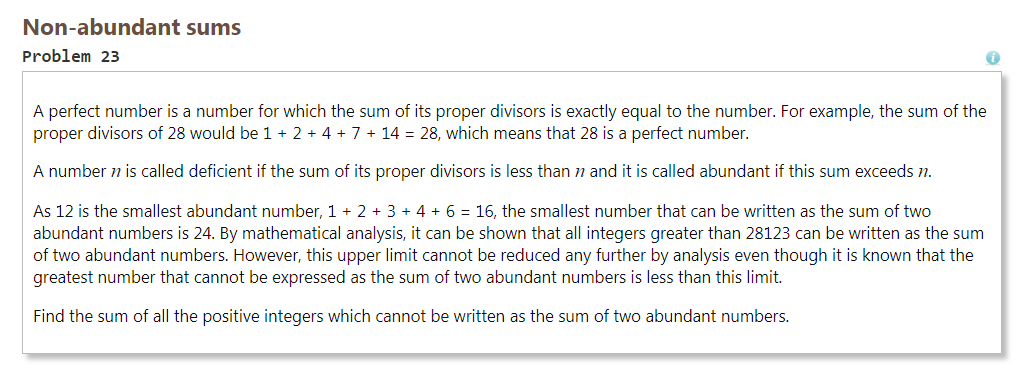

We also see increases in performance when we apply more complex functions onto sets of data:

In [17]:
def euler23_forloop():
    def factors(n):
        tup_list = [(i, int(n/i)) for i in range(1, int(n**.5)+1) if n % i == 0]
        small_list, large_list = zip(*tup_list)
        result = set(small_list + large_list)
        result.remove(n)
        return sum(result)
    num_list = list(range(1,28123+1))
    abundant = []
    for num in num_list:
        factor_sum = factors(num)
        if num > factor_sum:
            abundant.append(num)
    possible_sums = list(combinations(abundant, 2)) + [(x, x) for x in abundant]
    sum_list = [sum(sub_sum) for sub_sum in possible_sums if sum(sub_sum) <= 28124]
    result = 0
    for num in num_list:
        if num not in sum_list:
            result += num
    return result

In [41]:
time1 = time.process_time()
#sample = euler23_forloop()
time2 = time.process_time()
runtime = time2 - time1
print('For Loop time elapsed ~ {} seconds'.format(runtime))

For Loop time elapsed ~ 0.0 seconds


I commented the actual function call out because it takes too long and froze my computer. I wouldn't recommend uncommenting and pressing run on the above code, might as well just skip it as it takes quite a while. 

In [35]:
def euler23_sum():
    df = pd.DataFrame(list(range(1,28123+1)), columns = ['Num'])
    def factors(n):
        tup_list = [(i, int(n/i)) for i in range(1, int(n**.5)+1) if n % i == 0]
        small_list, large_list = zip(*tup_list)
        result = set(small_list + large_list)
        result.remove(n)
        return sum(result)

    df['sum_factors'] = df['Num'].apply(factors)

    abundants = df[df['sum_factors'] > df['Num']]['Num'].values.tolist()
    possible_sums = pd.Series(list(combinations(abundants, 2)) + [(x, x) for x in abundants])
    possible_sums = possible_sums.apply(sum)
    possible_sums = possible_sums[possible_sums <= 28123]
    check_set = set(possible_sums.values)
    df['two-sum'] = df['Num'].isin(check_set)
    return df[df['two-sum'] == False]['Num'].sum()

In [36]:
time1 = time.process_time()
sample = euler23_sum()
time2 = time.process_time()
runtime = time2 - time1
print('Vec time elapsed ~ {} seconds'.format(runtime))
print(sample)

Vec time elapsed ~ 19.406524399999995 seconds
4179871


There are definitely improvements to be made in the vectorized implementation, but it is more of a proof of concept.

#### Breakdown of steps for this particular problem in vectorization form:

Step 1: Generate DataFrame. The only main parameter for a DataFrame object is an iterable. The column parameter is optional but recommended as renaming columns can be a pain.

In [21]:
df = pd.DataFrame(list(range(1,28123+1)), columns = ['Num'])

Step 2: Create custom function that you want applied to your df column, it's most efficient if your function only takes one parameter. Apply functions can take more than one parameter, but it can be complex and inefficient to implement.

In [22]:
def factors(n):
    tup_list = [(i, int(n/i)) for i in range(1, int(n**.5)+1) if n % i == 0]
    small_list, large_list = zip(*tup_list)
    result = set(small_list + large_list)
    result.remove(n)
    return sum(result)

Step 3: Apply function to new column in DataFrame. By calling a name that doesn't exist in the DataFrame, in this case 'sum_factors', Pandas will automatically create a new column with this name. 

In [25]:
df['sum_factors'] = df['Num'].apply(factors)

Step 4: Grab values from dataframe that meet a criteria. In this case, it is any number that is less than the sum of its factors.

The syntax for filtering DataFrames is the following:
new_df = df[df['COLUMN'] CRITERIA]

A pythonic way is to also call the desired column since df[df['COLUMN'] CRITERIA] is a dataframe into the following:

In [26]:
abundants = df[df['sum_factors'] > df['Num']]['Num'].values.tolist()

The **.values** and **.tolist** method quickly grabs the values of the column that we just created and converts it into a list. 

Step 5: Get all possible combinations of 2 from the **abundants** list and also add the double combinations **(x, x)** because the combinations function does not include combinations that contain the same number. Put it into a Series for easy function application.

In [27]:
possible_sums = pd.Series(list(combinations(abundants, 2)) + [(x, x) for x in abundants])

Step 6: Apply the sum function and then filter the Series that is under our max integer of 28123. The syntax is very similar to how you would filter a pandas column.

In [30]:
possible_sums = possible_sums.apply(sum)
possible_sums = possible_sums[possible_sums <= 28123]

Step 7: We want to filter this DataFrame column by numbers that are NOT in the possible_sums list. We are creating a set to get rid of duplicate variables and reduce computations:

In [37]:
check_set = set(possible_sums.values)

We are then filtering using the **.isin** method, which outputs a list of booleans. The syntax is pretty self explanatory as we have the column we want to filter, and we then assign this column of booleans to a new dataframe column. 

In [39]:
df['two-sum'] = df['Num'].isin(check_set)

Step 8: The **.isin** method only outputs booleans so we want to then use this to actually filter the dataframe, then sum it.

In [40]:
df[df['two-sum'] == False]['Num'].sum()

4179871

Not all problems will benefit from vectorization. When you have smaller datasets or iterations, it may even take longer because of the extra time it takes to load data into DataFrames. However, the benefit of it is that you have more readable data that can be easily called in the future when you work with actual projects and data. 

Pandas DataFrames can be slower than some other implementations, but I found it to be a good first step in writing more pythonic and efficient code. 